# Store Demand Forecasting

## Executive Summary

Many stores experience seasonality in its sales, which affects decisions concerning staffing, inventory, and marketing budget. Having a good grasp of demand is thus important in many aspects of strategy and operations. This project explores such seasonalities and draws conclusions from key seasonal trends while predicting future demand. ARIMA was shown to be effective in a relatively simple dataset with increasing overall demand and annual demand fluctuation. Nevertheless, it is also important to note that, ideally, these models should be built for each store, each item to be the most accurate, which may not be feasible in reality.

## Data Description

The data was taken from Kaggle's Store Item Demand Forecasting Challenge. There are relatively few columns, and minimal cleaning was required. 

It can be found here: https://www.kaggle.com/c/demand-forecasting-kernels-only

## Some Guiding Questions

1. Is the store experiencing and increase in sales year over year? By how much?
2. Which months are expected to generate the highest revenue?
3. What is the expected total sales in the coming year?

## Main Learning Objectives

1. Decompose and visualize time-series data into seasonality and overall trends
2. Running ARIMA model using Python to predict future trends
3. Visualize seasonality using Plotly package

## I. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from plotnine import *
import plotly.express as px


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
## Import and check for missing data
data = pd.read_csv('store_data.csv')
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [3]:
## Convert to appropriate data types
data['date'] = pd.to_datetime(data['date'])

## II. Store Sales Trends

In [4]:
## Compare total sales between stores

store_summary = data.groupby(['store'], as_index = False).agg({
    'date':['min','max'],
    'sales': ['sum', 'count']
})

store_summary.columns = [" ". join(x) for x in store_summary.columns.ravel()]

store_summary

,store,date min,date max,sales sum,sales count
0,1,2013-01-01,2017-12-31,4315603,91300
1,2,2013-01-01,2017-12-31,6120128,91300
2,3,2013-01-01,2017-12-31,5435144,91300
3,4,2013-01-01,2017-12-31,5012639,91300
4,5,2013-01-01,2017-12-31,3631016,91300
5,6,2013-01-01,2017-12-31,3627670,91300
6,7,2013-01-01,2017-12-31,3320009,91300
7,8,2013-01-01,2017-12-31,5856169,91300
8,9,2013-01-01,2017-12-31,5025976,91300
9,10,2013-01-01,2017-12-31,5360158,91300


The data seems very consistent - all stores have the same observational period and number of observations. There is definitely variation of total sales between stores, though.

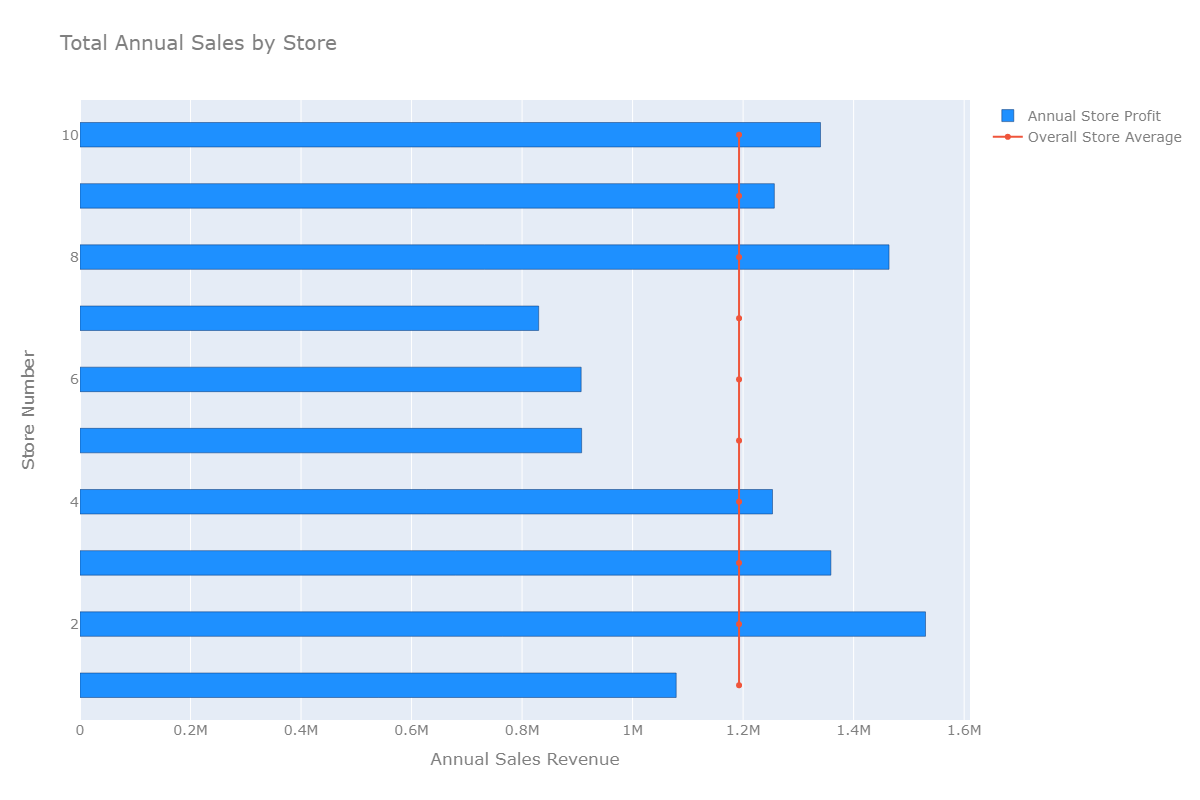

In [5]:
## Get a visualization of difference in sales of different stores

fig = go.Figure()

average = (store_summary['sales sum'].mean())//4
average = [average for i in range(len(store_summary.index))]

fig.add_trace(
    go.Bar(y = store_summary['store '], x = store_summary['sales sum']//4,
          name = 'Annual Store Profit',
          width = 0.4,
          marker_color= 'rgb(30,144,255)', marker_line_color='rgb(8,48,107)',
          orientation = 'h')
)

fig.add_trace(
    go.Scatter(y = [store for store in store_summary['store '].unique()], x = average,
               name = 'Overall Store Average',
               orientation = 'h')
)

fig.update_layout(
    title_text = 'Total Annual Sales by Store',
    xaxis_title = 'Annual Sales Revenue',
    yaxis_title = 'Store Number',
    font = dict(
        size =14,
        color = "#7f7f7f"
    )
)


fig.show("png", width=1200, height=800)

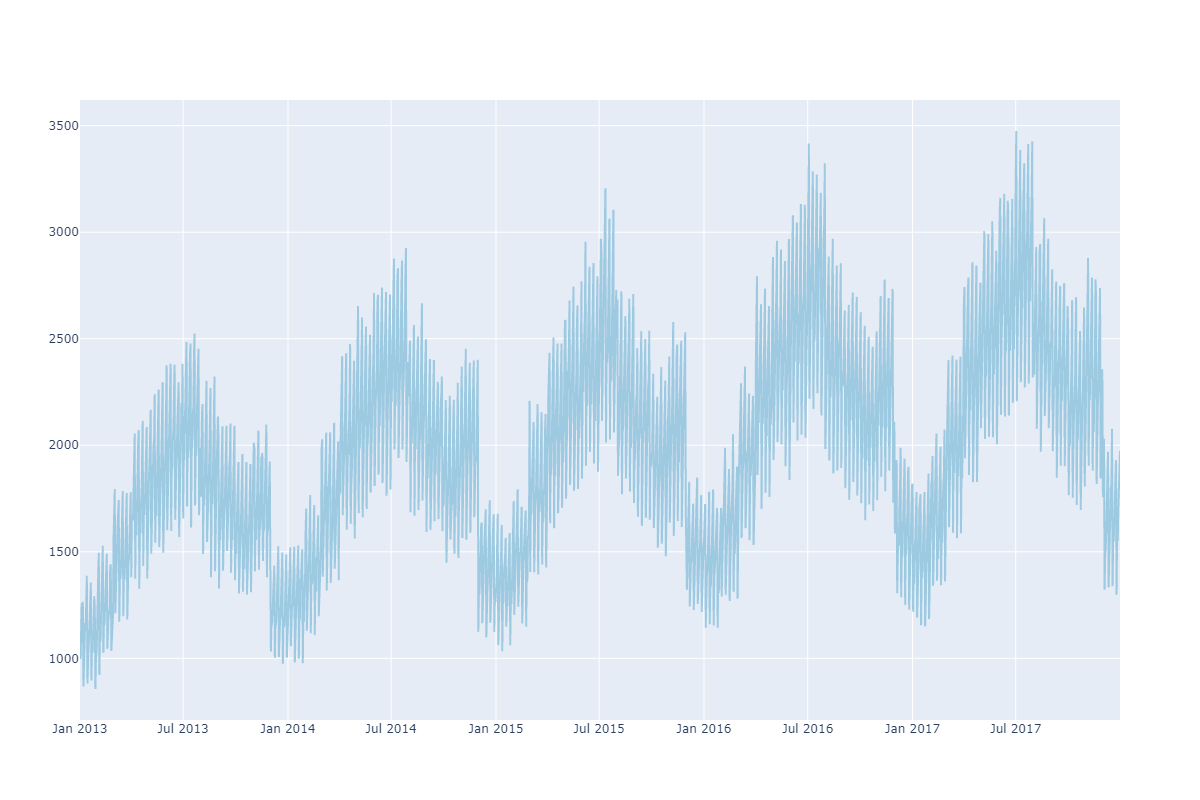

In [6]:
## get a peak at seasonality at the store level for different stores
def store_graph(store_number = 1):
    store_level = data.groupby(['store','date'], as_index = False).agg({
    'sales':'sum'    
    })
    fig = go.Figure()

    subset = store_level.loc[store_level['store'] == store_number]

    fig.add_trace(
        go.Scatter(x = subset['date'],y = subset['sales'],
                  marker_color='rgb(158,202,225)')
    )

    fig.show("png", width=1200, height=800)

    
store_graph(store_number = 5)

The code above helps us look at the trend within one store at a time. From this we can see that there seems to be a yearly cycle of sales, with average sales increasing throughout the observed years. The seasonality and increase make this dataset look artificial - real-life data is proabbly much messier than this.

However, it is sometimes helpful to look into how the trend differs. Below we can see all store's sales trend plotted out.

In [7]:
## First aggregate stores

store_summary = data.groupby(['store','date'], as_index = False).agg({'sales':'sum'})

store_summary.head(5)

,store,date,sales
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499


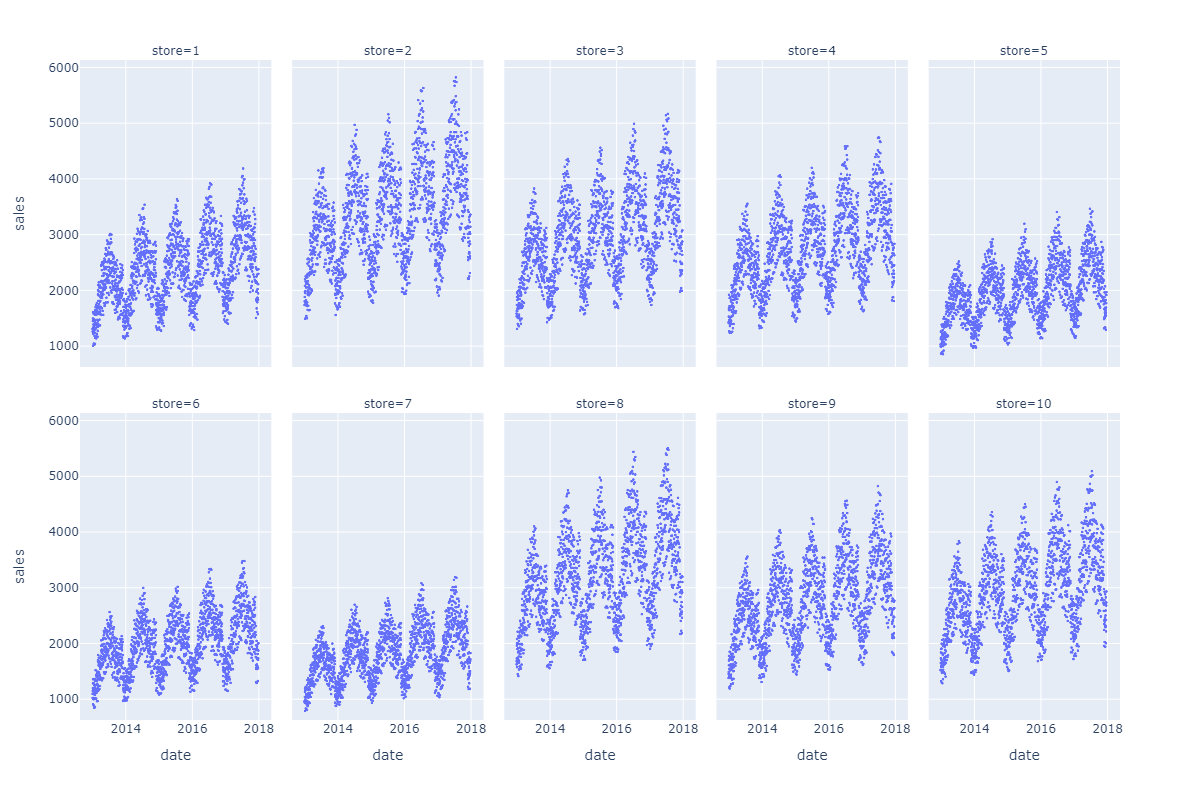

In [8]:
fig = px.scatter(store_summary, x='date', y='sales', 
                facet_col='store', facet_col_wrap=5)

fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.show("png", width=1200, height=800)

### Conclusion

From the above graphs we can see that every store experiences a similar, annual fluctuation of sales. All stores also appear to be increasing in overall annual sales over the years. The peak season in sales seems to be around summer time (July - August).

In the next section, we will focus the forecasting on just one store. 

## III. Seasonality Decomposition

In order to dive deeper into the trends, we can focus on just one store and study just how much of the fluctuations in sales is from seasonality cycles, and how much of it is from an overall increase in demand. 

In [9]:
## Filter out any non-store 2 data
store_data = data.loc[data['store']== 2]

## Decompose aggregate sales trends over years
agg_data = store_data.groupby('date').agg({'sales':'sum'})

## Use resample to get less data points for plotting - similar to groupby, but using a set timeframe specified
series = agg_data['sales'].resample('W').mean()

## Decompose into components
decomposition = seasonal_decompose(series, model = 'additive')

In [10]:
def get_results(df = decomposition):
    seasonal = pd.DataFrame(decomposition.seasonal)
    trend = pd.DataFrame(decomposition.trend)
    resid = pd.DataFrame(decomposition.resid)
    obs = pd.DataFrame(decomposition.observed)
    result = seasonal.merge(trend, left_index=True, right_index = True)
    result = result.merge(resid, left_index=True, right_index = True)
    result = result.merge(obs, left_index=True, right_index = True)
    result = result.reset_index()
    return result

result = get_results()


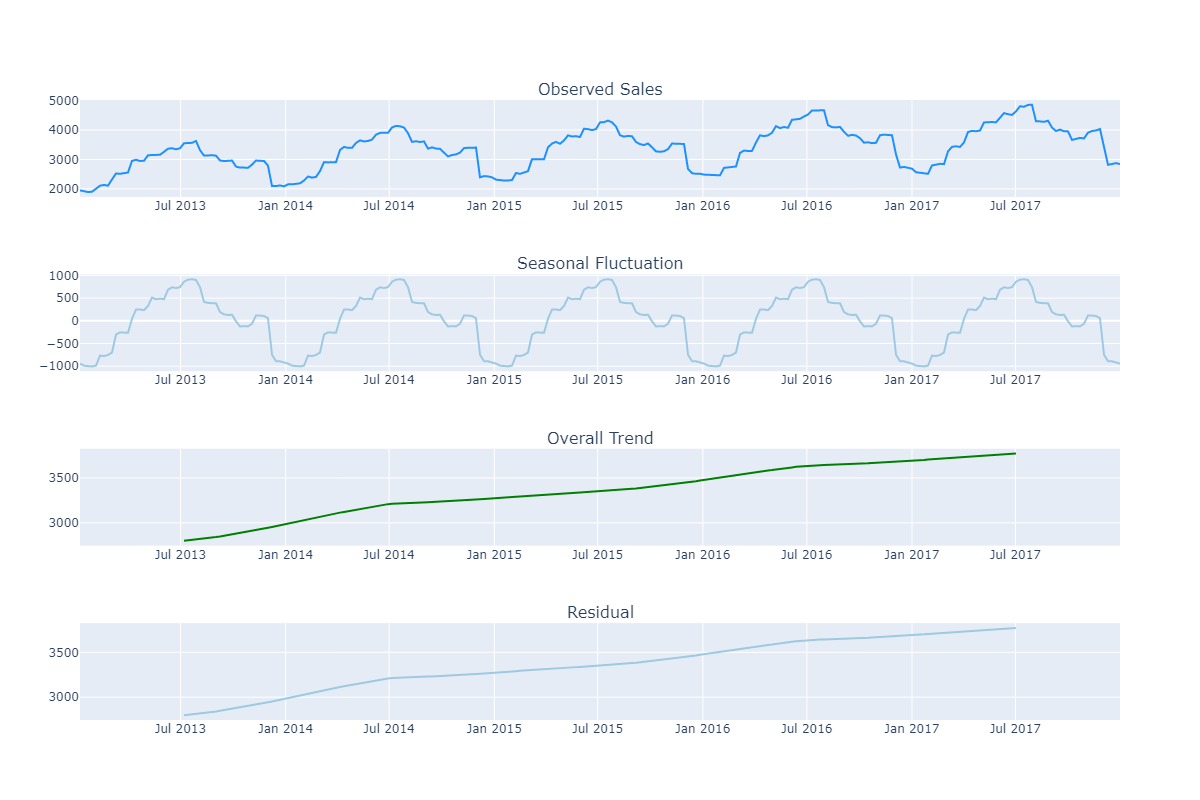

In [11]:
fig = make_subplots(
    rows = 4, cols = 1,
    column_widths = [0.6],
    row_heights = [0.6, 0.6, 0.6, 0.6],
    subplot_titles = ['Observed Sales',
                      'Seasonal Fluctuation',
                      'Overall Trend',
                      'Residual']    
)


fig.add_trace(
    go.Scatter(x = result['date'], y = result['sales'],
              marker_color='rgb(30,144,255)'),
    row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x = result['date'], y = result['seasonal'],
              marker_color='rgb(158,202,225)'),
    row = 2, col = 1
)

fig.add_trace(
    go.Scatter(x = result['date'], y = result['trend'],
              marker_color='rgb(0,128,0)'),
    row = 3, col = 1
)

fig.add_trace(
    go.Scatter(x = result['date'], y = result['trend'],
              marker_color='rgb(158,202,225)'),
    row = 4, col = 1
)

fig.update_layout(showlegend=False,
                  width = 800,
                  height = 1000)

fig.show("png", width=1200, height=800)

### Conclusion:

The decomposition allows us to see the seasonal flucutations and overall trend separates. The overall trend is probably what is the most informative in terms of future projections (without building any models yet) - it looks like there is, in fact, an increase in sales over the observed years. 

The next section will focus on forecasting the trends of sales for just one product in one store to simplify the analysis.



## IV. Forecasting Model - ARIMA

In [12]:
## Find out the most popular item in store to study

store_data.groupby('item').agg({'sales':'sum'}).sort_values(by = 'sales',ascending = False).head(5)

,sales
item,
28,205677
15,205569
18,197422
13,197031
25,188856


In [13]:
## First select dataset 
store_data = store_data.loc[store_data['item']==28]
store_data = store_data.groupby('date').agg({'sales':'sum'})

## Get monthly mean - it would be easier to work with this way
series = agg_data['sales'].resample('MS').mean()
store_data = series.to_frame()

In [14]:
## Divide into train and test sets - last 6 months for prediction
train = store_data.loc['2013-01-01':'2017-06-30']
test = store_data.loc['2017-07-01':]

### Some notes on ARIMA

ARIMA is probably the most well-known time series modeling technique. The basic ARIMA has 3 parameters, each describing a different pattern in a time series dataset:

1. Seasonality: described by parameter (p), the order of the autoregressive (AR) part, ie the number of time lags to use for the next data. This incorporates past information into the current prediction. 

2. Trend: described by  parameter (d), the degree of differencing (part "I"). This is used to make a model "stationary". Depending on the complexity of the model, the number of times the data gets past values subtracted from it could vary.

3. Noise: described by q - the "moving average" part. It is the number of lagged forecast errors that should go into the model.

The fact that there is a clear increasing trend and seasonal fluctuation also tell us that we have to model this into the forecasting model, since most time series model requires the data to be stationary, that is:

1. Constant mean over time
2. Constant variance over time
3. Constant autocorrelation
4. No seasonality



### Check for stationary time-series

A quick way to check if a time series is stationary is to just plot the rolling mean and standardeviation


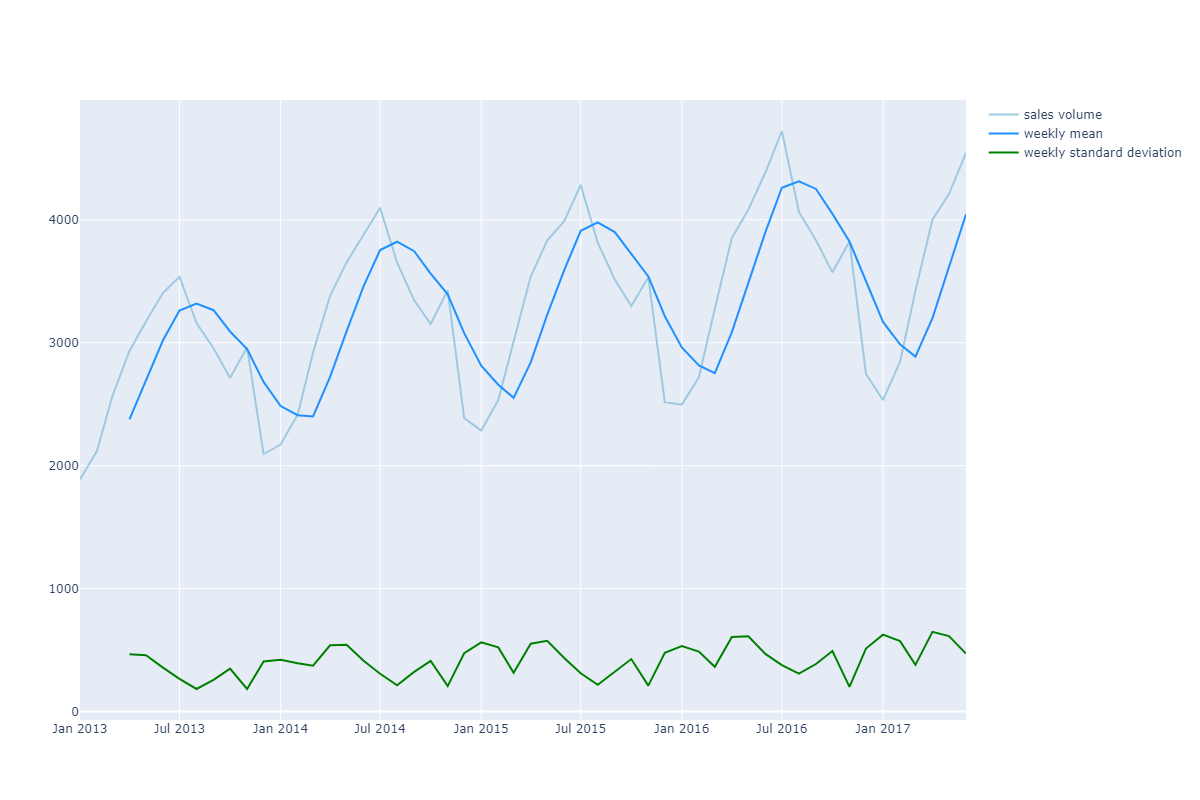

In [15]:
## First see how the data looks like with a moving average window of 4 months
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'],
                  marker_color='rgb(158,202,225)',
                  name = 'sales volume')
    )

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'].rolling(4).mean(),
                  marker_color='rgb(30,144,255)',
                  name = 'weekly mean')
    )

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'].rolling(4).std(),
                  marker_color='rgb(0,128,0)',
                  name = 'weekly standard deviation')
    )

fig.show("png", width=1200, height=800)

We can see fluctuations of mean and standard deviation from the above graph pretty easily.

Even though it is obvious from plotting alone that this is not a stationary dataset, it is still useful to use statistical test to further justify the analysis. One such test is the Augmented Dickey-Fuller test (ADF), which is a unit root test.

The intuition is this: the test determins how strongly a series of data is defined by a trend (consant, linear, quadartic, etc.)

The null hypothesis states that the time-series can be represented by a unit root, ie non-stationary but has some sort of time-dependent structure. The alternative states that it is indeed stationary. 

p-value <=0.05 thus suggests that the null hypothesis can be rejected and the data is stationary. 

In [16]:
## Check for stationary property of original dataset

adf_test = adfuller(train['sales'], autolag = 'AIC', maxlag = 20)
adf_result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(adf_result)

Test Statistic                 -0.821259
p-value                         0.812797
#Lags Used                     18.000000
Number of Observations Used    35.000000
dtype: float64


The p-value is high, meaning that (unsurprisingly) there is non-stationary components in the dataset. Now we can try again with some differencing (also helps to figure out what d should be)

In [17]:
adf_test = adfuller(train['sales'].diff().dropna(), autolag = 'AIC', maxlag = 20)
adf_result = pd.Series(adf_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(adf_result)

Test Statistic                 -2.800712
p-value                         0.058172
#Lags Used                     17.000000
Number of Observations Used    35.000000
dtype: float64


The p-value drops dramatically, suggesting that differencing does help us make the series stationary. We can also verify this by plotting again.

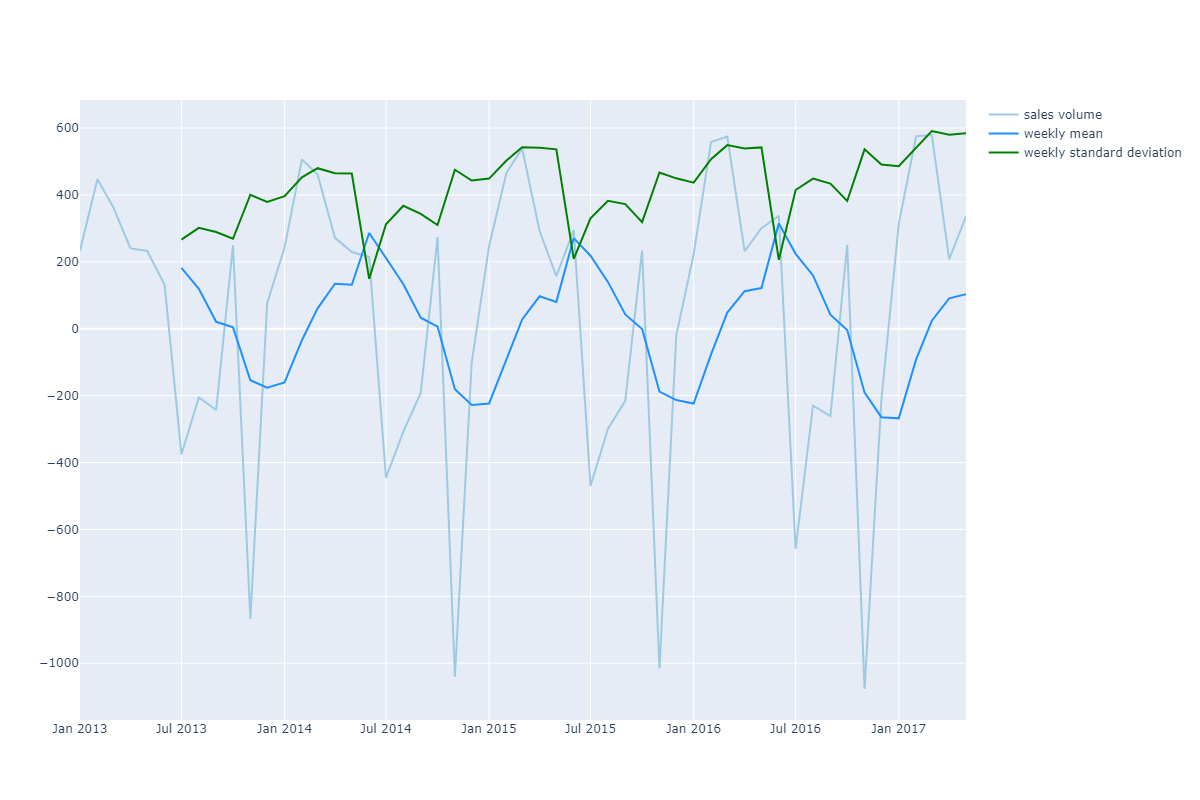

In [18]:
## See how differencing the data leads to a stationary time series
fig = go.Figure()

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'].diff().dropna(),
                  marker_color='rgb(158,202,225)',
                  name = 'sales volume')
    )

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'].diff().dropna().rolling(7).mean(),
                  marker_color='rgb(30,144,255)',
                  name = 'weekly mean')
    )

fig.add_trace(
        go.Scatter(x = train.index,y = train['sales'].diff().dropna().rolling(7).std(),
                  marker_color='rgb(0,128,0)',
                  name = 'weekly standard deviation')
    )

fig.show("png", width=1200, height=800)

That's a dramatic difference. Now we can start modeling using a difference value of 1.

### Selecting Parameters for ARIMA

The differenced dataset had a much smaller p-value than the original dataset, suggesting that differencing of 1 indeed makes the dataset stationary for analysis. Differencing of 2 also works - we could try different combinations to see which one generates the best results. We can tentatively assign a value of 1 for d and D, but we still have to find the same for p and q (and its equivalent within season - P and Q)

Now we also have to find the p value for the auto-regression part of the analysis. This can be done by the ACF and PACF graphs:

__ACF (Autocorrelation):__ This graph can be seen as a correlation plot between value and t with values at t-1, t-2, t-3, etc. High ccorrelation should be expected to have more predictive power in the model


__PACF (Partial Autocorrelation):__ Autocorrelated model has a pecial property not present in panel data - if t is correlated with t-1, and t-1 is correlated with t-2, this implies that t is also somewhat correlated to t-2. We can see the part of these partial correlations in the PACF graph. This graph helps us see the correlation of t-n and t without the effects of all the lag terms in between

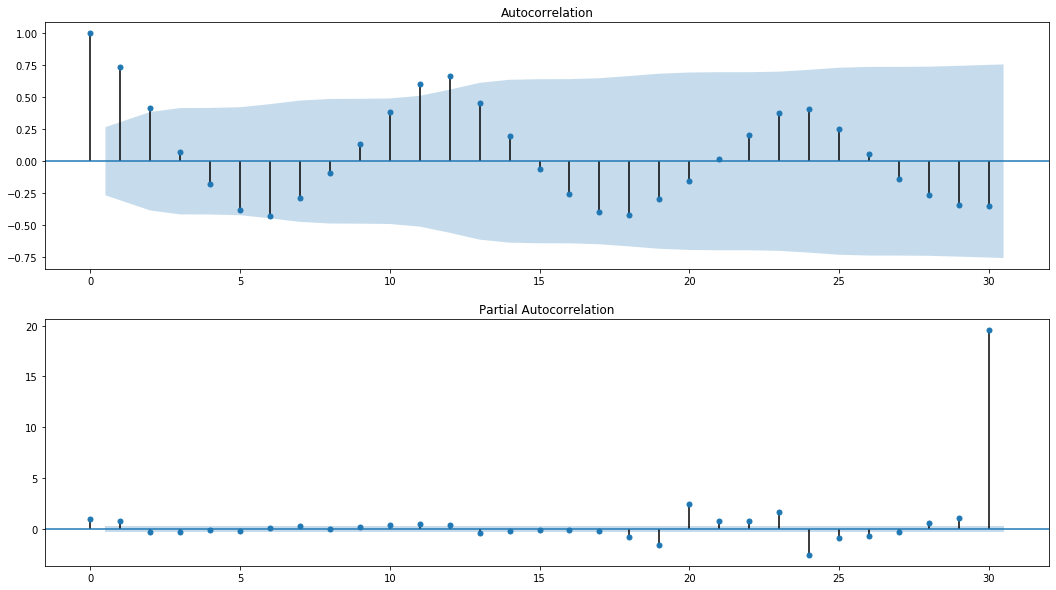

In [19]:
## These graphs should give us a clue of what values of p to use in the AR part of the model

fig, ax = plt.subplots(2,1)
fig.set_size_inches(18, 10)
fig = sm.graphics.tsa.plot_acf(train['sales'], lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train['sales'], lags=30, ax=ax[1])
plt.show()

There is a repetitive pattern every 12 months, suggesting an annual trend and we should add a seaonality term to the model. So the regualr ARIMA probably won't suffice.

We can also see that the most significant correlation still happens at lag value of 1 from the PACF, so we can start our modeling here with these values.

In [20]:
arima1 = ARIMA(train['sales'], (1,1,0)).fit(disp=False)
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                   53
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -394.453
Method:                       css-mle   S.D. of innovations            412.840
Date:                Fri, 10 Apr 2020   AIC                            794.906
Time:                        13:11:00   BIC                            800.817
Sample:                    02-01-2013   HQIC                           797.179
                         - 06-01-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            52.7526     73.194      0.721      0.471     -90.704     196.209
ar.L1.D.sales     0.2293      0.133      1.723      0.085      -0.032       0.490
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.3616           +0.0000j            4.3616            0.0000
-----------------------------------------------------------------------------
"""

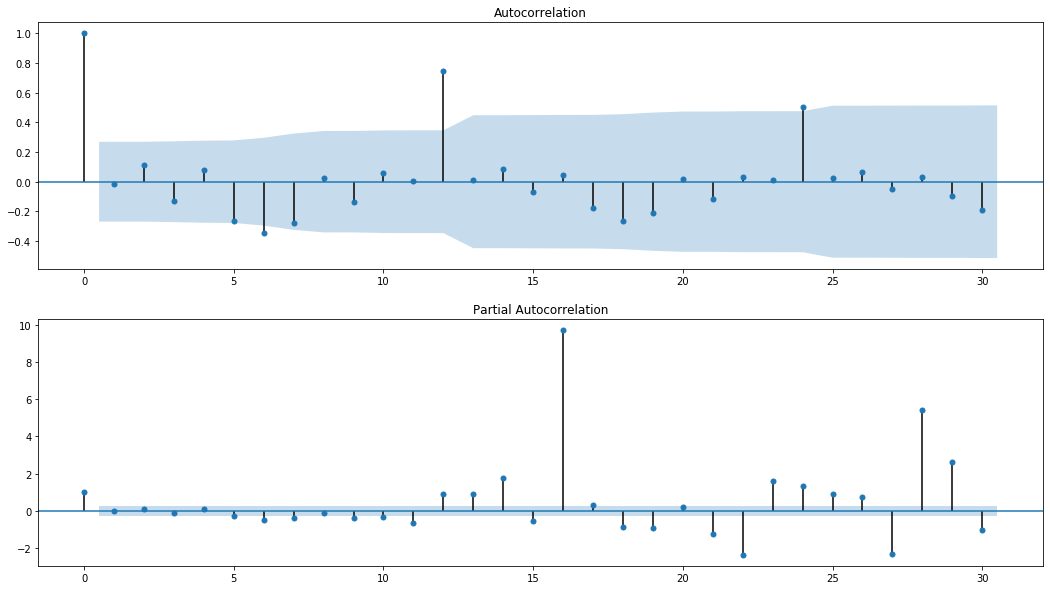

In [21]:
## Plot out the autocorrelation of residuals to see how good the model is without any seasonal effects

fig, ax = plt.subplots(2,1)
fig.set_size_inches(18, 10)
fig = sm.graphics.tsa.plot_acf(arima1.resid, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(arima1.resid, lags=30, ax=ax[1])
plt.show()

All the auto-correlated terms seem to be gone, but definitely there is still a trend going on every 12 months. This can be taken into account using SARIMA.

## V. SARIMA model

Because the data also shows that there is very clear seaonality in the data, we should also incorporate seasonality into the model using SARIMA. This adds 4 more parameters to the ARIMA model: P, D, Q, and m.

P, D, Q are analogous to the base ARIMA model, but applied to the seasonal component. m is the seasonal component. If the data is on a monthly level and the seasonality is annual, then m = 12. Large number of m takes up lots of memory so I decided to convert the data from daily to monthly level in order to properly capture the annual trend.

In [22]:
## Specify parameters to tune

P = D = Q = q = range(0, 2)

pdq = [(1, 1, x) for x in q]

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

trends = ['n','c','t','ct']

In [23]:
## Grid search through all possible combinations
for param in pdq:
    for seasonal_param in seasonal_pdq:
        for trend in trends:
            try:
                model = sm.tsa.statespace.SARIMAX(train['sales'],
                                                  trend = trend,
                                                  freq = 'MS',
                                                  order=param,
                                                  seasonal_order = seasonal_param,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)
                results = model.fit()
                print('SARIMA{}x{} with {} - AIC:{}'.format(param, seasonal_param, trend, results.aic))
            except:
                continue

SARIMA(1, 1, 0)x(0, 0, 0, 12) with n - AIC:779.1632920455187
SARIMA(1, 1, 0)x(0, 0, 0, 12) with c - AIC:780.7745677421177
SARIMA(1, 1, 0)x(0, 0, 0, 12) with t - AIC:780.8176305816513
SARIMA(1, 1, 0)x(0, 0, 0, 12) with ct - AIC:782.7672282620729
SARIMA(1, 1, 0)x(0, 0, 1, 12) with n - AIC:577.2603814425395
SARIMA(1, 1, 0)x(0, 0, 1, 12) with c - AIC:579.1926895036984
SARIMA(1, 1, 0)x(0, 0, 1, 12) with t - AIC:579.150114206241
SARIMA(1, 1, 0)x(0, 0, 1, 12) with ct - AIC:581.1497695029276
SARIMA(1, 1, 0)x(0, 1, 0, 12) with n - AIC:468.5136090326829
SARIMA(1, 1, 0)x(0, 1, 0, 12) with c - AIC:470.43576736458624
SARIMA(1, 1, 0)x(0, 1, 0, 12) with t - AIC:470.39901078520916
SARIMA(1, 1, 0)x(0, 1, 0, 12) with ct - AIC:472.3833721021858
SARIMA(1, 1, 0)x(0, 1, 1, 12) with n - AIC:964.7193351438787
SARIMA(1, 1, 0)x(0, 1, 1, 12) with c - AIC:1248.7422850326666
SARIMA(1, 1, 0)x(0, 1, 1, 12) with t - AIC:1166.898984843661
SARIMA(1, 1, 0)x(0, 1, 1, 12) with ct - AIC:1143.8916020133297
SARIMA(1, 1, 0)x(

It looks like the best parameters come from (1, 1, 0)x(1, 1, 0, 12) with 'n' as trend. It has the lowest AIC, which is also much lower than the simple ARIMA model but that is not surprising. So we can go ahead and use this as the final model and build some predictions.

In [24]:
## Build final model

final_model = sm.tsa.statespace.SARIMAX(train['sales'],
                                        trend = 'n',
                                        freq = 'MS',
                                        order = (1,1,0),
                                        seasonal_order = (1,1,0,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results = final_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3066      0.209     -1.464      0.143      -0.717       0.104
ar.S.L12      -0.1416      0.207     -0.683      0.495      -0.548       0.265
sigma2      5080.3849   1261.697      4.027      0.000    2607.504    7553.266


All features are significant except for the lag12, but still adds to the model. We can see the model performance better with some plots

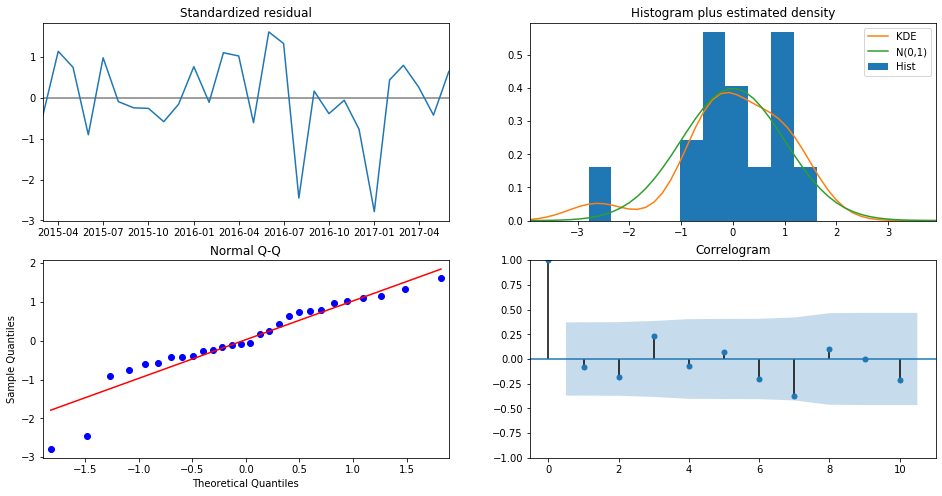

In [25]:
## Use built-in tools to see model performance
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Coorelogram and Noamrl-Q-Q look good, even though the histogram suggests that the model still isn't that perfect, and we can see a pretty ovious spike at aroun 2017-1 in the standardized residual. This is probably okay for now.

In [26]:
## Validate the model on the testing set to see how it does

forecast = results.get_prediction(start=pd.to_datetime('2017-07-01'), end = pd.to_datetime('2017-12-01'), dynamic=False)
forecast_ci = forecast.conf_int()
forecast_mean = forecast.predicted_mean.to_frame()


In [27]:
forecast_full = forecast_ci.merge(forecast_mean, how = 'left', left_index=True, right_index=True)
forecast_full.rename(columns = {0:'mean'},
                     inplace = True)
forecast_full

,lower sales,upper sales,mean
2017-07-01,4720.071871,4999.471867,4859.771869
2017-08-01,4063.334702,4403.337448,4233.336075
2017-09-01,3789.287033,4194.260882,3991.773958
2017-10-01,3508.955630,3966.042650,3737.499140
2017-11-01,3733.373477,4238.255134,3985.814305
2017-12-01,2643.369399,3191.601616,2917.485507


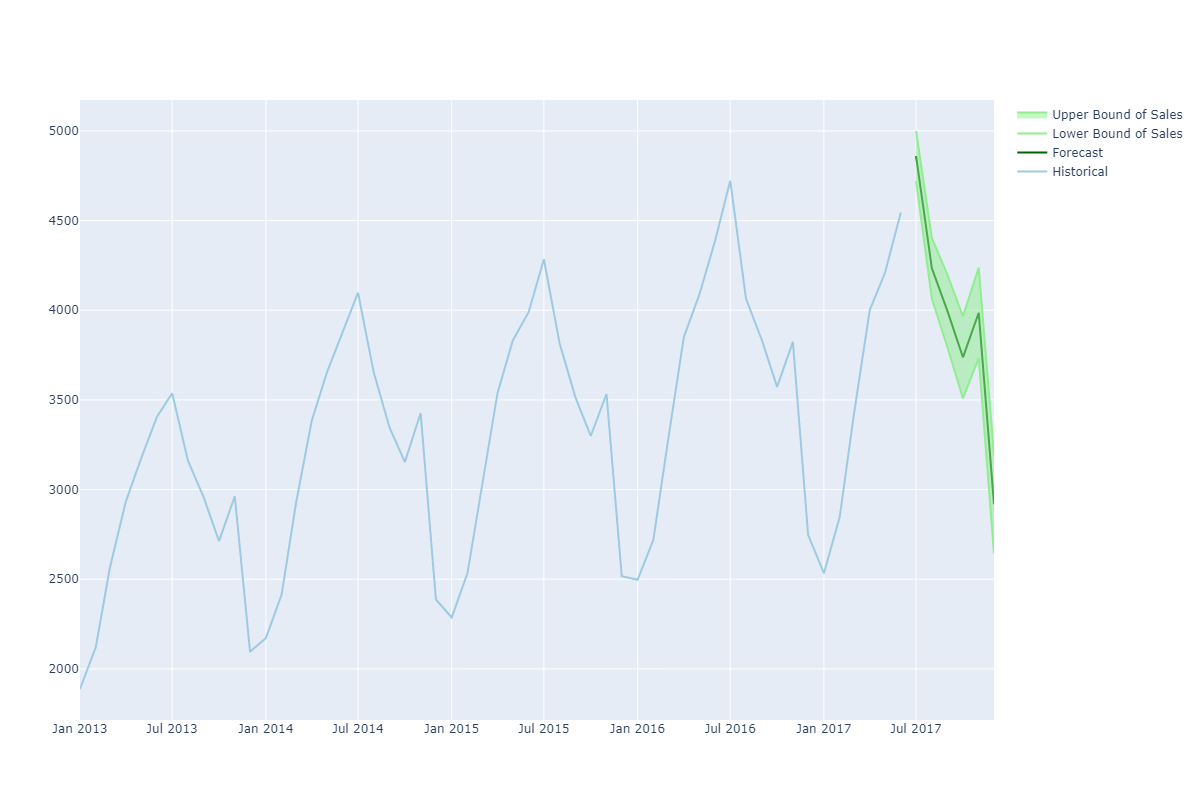

In [28]:
data_plot = pd.merge(train, forecast_full, how = 'outer',left_index=True, right_index=True)

fig = go.Figure()


fig.add_trace(
    go.Scatter(x = data_plot.index, y = data_plot['sales'],
               marker_color='rgb(158,202,225)',
               name = 'Historical')
)

fig.add_trace(
    go.Scatter(x = data_plot.index, y = data_plot['mean'],
               marker_color='rgb(0,100,0)',
               name = 'Forecast')
)

fig.add_trace(
    go.Scatter(x = data_plot.index, y = data_plot['lower sales'],
    fill=None,
    mode='lines',
    line_color='rgb(144,238,144)',
    name = 'Lower Bound of Sales')
)
fig.add_trace(
    go.Scatter(x = data_plot.index, y = data_plot['upper sales'],
    fill='tonexty', 
    mode='lines', line_color='rgb(144,238,144)',
    name = 'Upper Bound of Sales')
)




fig.show("png", width=1200, height=800)

From the graph, it looks like our model successfully captured the seasonality within a year. That's good news!

## VI. Key Takeaways

This notebook ended up taking me longer than expected, since I had little experience dealing with time series data. But now ARIMA makes a lot more sense!

Some key findings from this project:

1. Even though the dataset looks synthetic, the annual seasonal trend in sales is probably quite realistic as most retailers would experience similar trends.
2. Despite difference in sales between stores, the seasonal trends are very similar - it is possible to extrapolate insights from one example and apply to all.
3. Nevertheless, it is probaly best to build separate models for separate stores and items. This would mean building different ARIMA models for different items.